In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [2]:
# load data into a Pandas DataFrame
df = pd.read_csv('cardio_train.csv', sep=';') 
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
id             70000 non-null int64
age            70000 non-null int64
gender         70000 non-null int64
height         70000 non-null int64
weight         70000 non-null float64
ap_hi          70000 non-null int64
ap_lo          70000 non-null int64
cholesterol    70000 non-null int64
gluc           70000 non-null int64
smoke          70000 non-null int64
alco           70000 non-null int64
active         70000 non-null int64
cardio         70000 non-null int64
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


There are no null values in this dataset, and all data values are either ints or floats.

In [4]:
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


From an initial statistical overview of the dataset, we infer that some data features are binary or ordinal, whereas other features are continuous. Further, the minimum and maximum values for some features, notably for systolic and diastolic blood pressure (ap_hi and ap_lo), are unrealistic. This suggests the presence of outliers in the data.

In [5]:
# check distribution of target variable
df.cardio.value_counts()

0    35021
1    34979
Name: cardio, dtype: int64

35,021 out of 70,000 cases in this dataset are labelled as having no cardiovascular disease, and 34,979 cases are labelled as having cardiovascular disease. This suggests that the dataset is roughly balanced. 

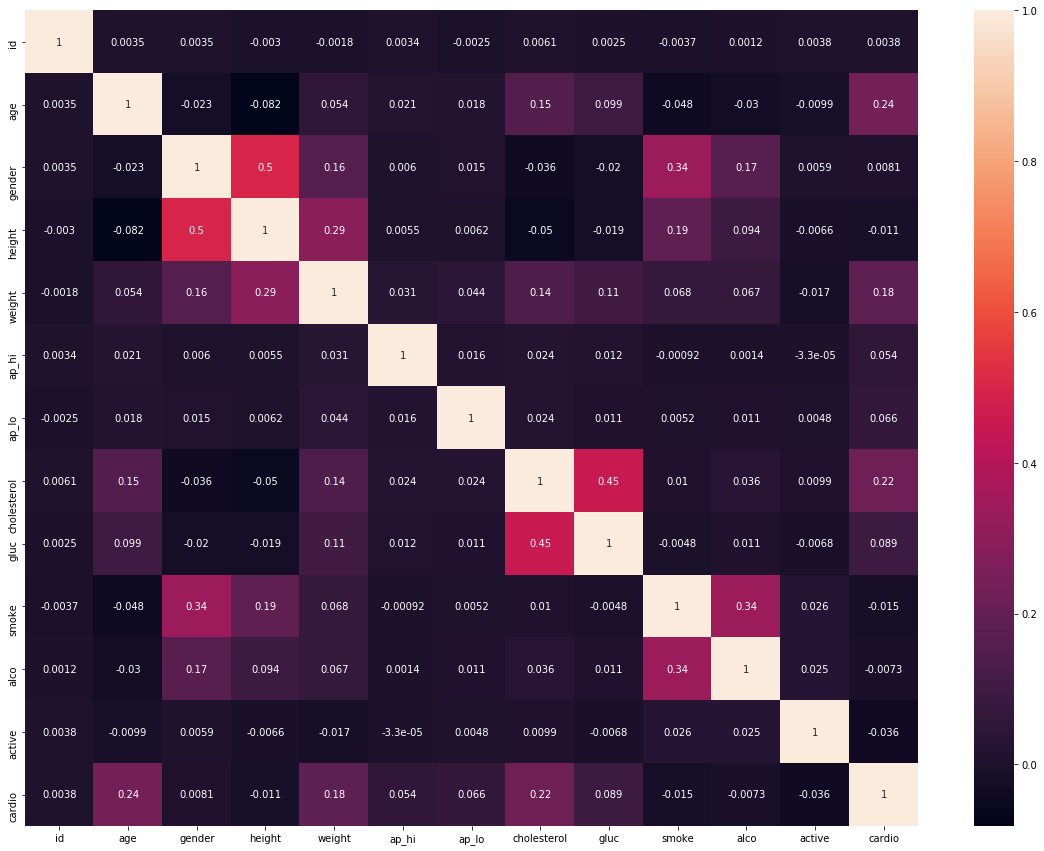

In [6]:
# check correlations
plt.subplots(figsize=(20,15))
sns.heatmap(df.corr(), annot=True)

A heatmap shows correlations between variables in the dataset. From the above heatmap, we see that no features directly correlate with the label (cardio) and that generally, there do not exist significant correlations between other variables. However, correlations exist between a select few variables:
- Height and gender are correlated with a score of 0.5.
- Glucose and cholesterol are correlated with a score of 0.45.
- Smoking habits and gender are correlated with a score of 0.34.

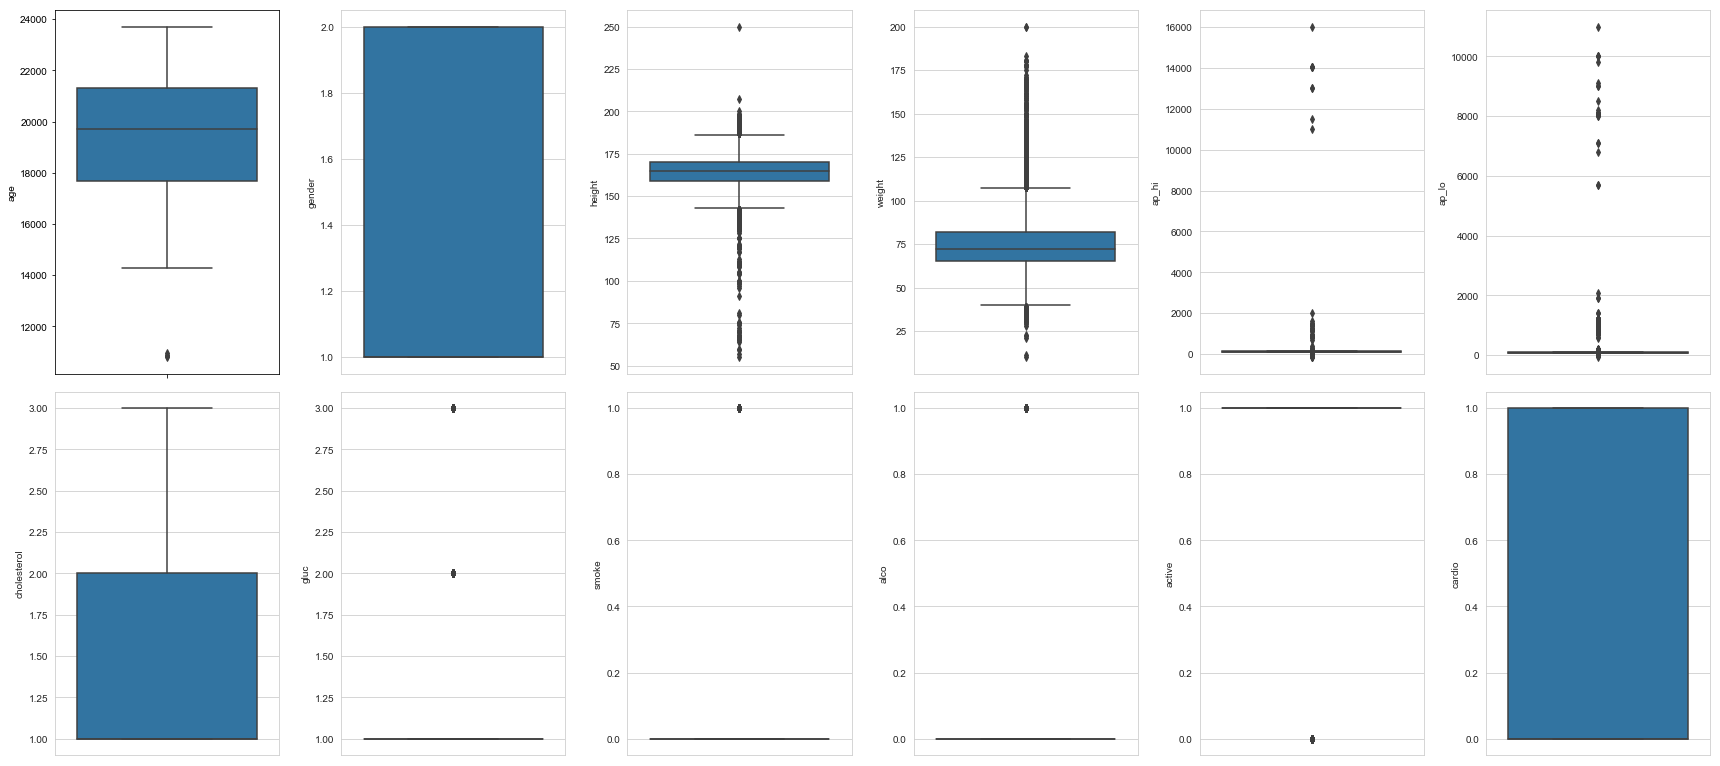

In [7]:
# check outliers

def check_outliers(df):
    l = df.columns.values
    number_of_columns=(len(l)-1)/2
    number_of_rows = 2
    
    plt.figure(figsize=(4*number_of_columns,8*number_of_rows))
    for i in range(1,len(l)):
        plt.subplot(number_of_rows + 1,number_of_columns,i)
        sns.set_style('whitegrid')
        sns.boxplot(df[l[i]],orient='v')
        plt.tight_layout()
        
check_outliers(df)

The above boxplots confirm our suspicion that there are outliers in the dataset. There appear to be several outliers in the systolic and diastolic variables (ap_hi and ap_lo). These outliers might be explained by human error when entering data into the .csv format. Our prediction model might benefit if these outliers were removed from the data.

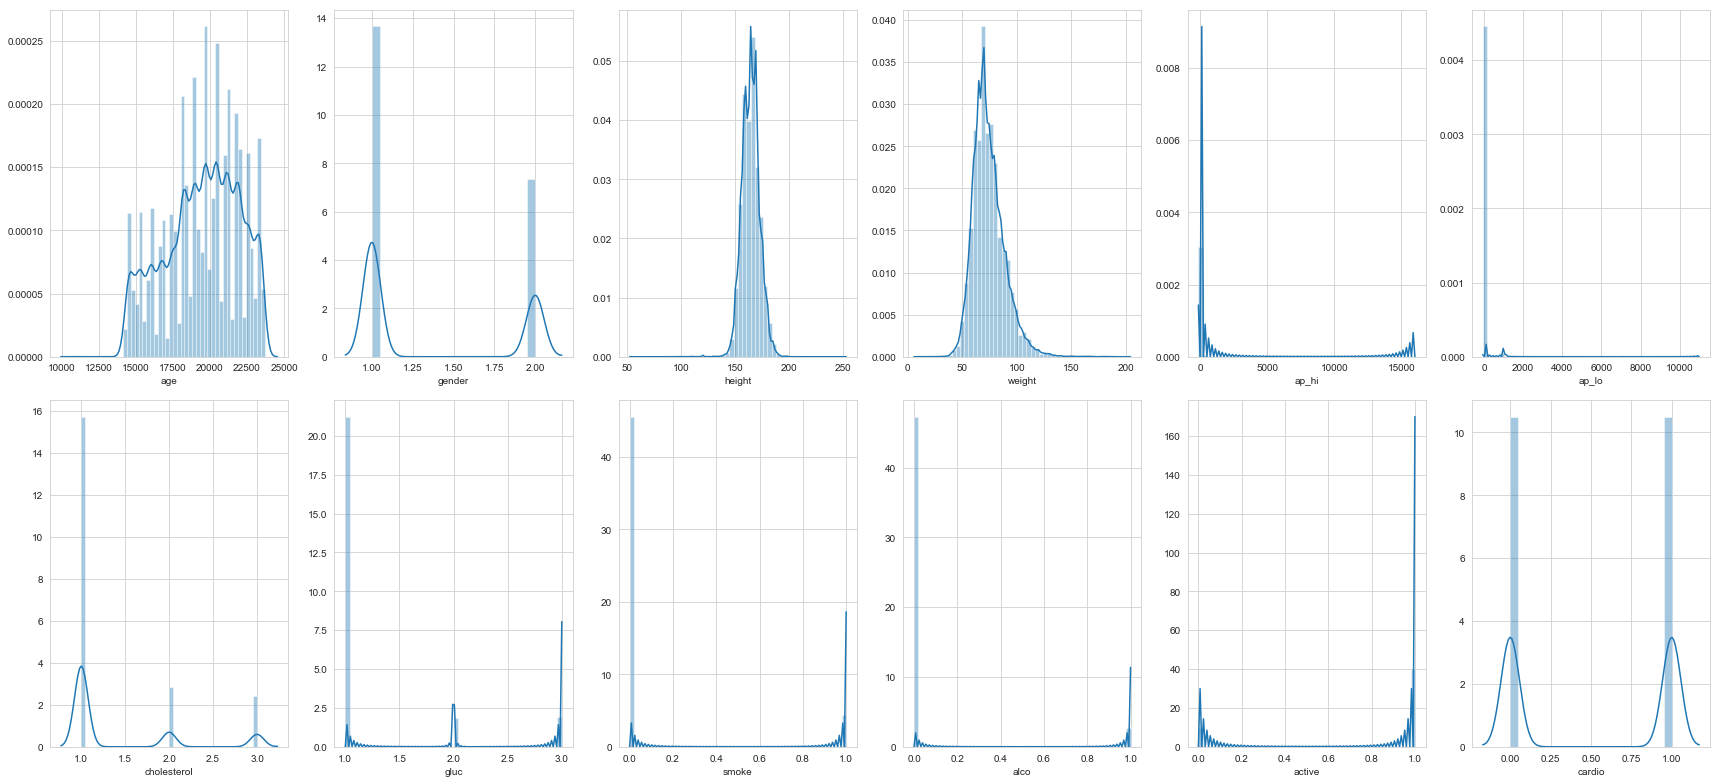

In [8]:
# check distribution and skew
def check_dist(df):
    l = df.columns.values
    number_of_columns=(len(l)-1)/2
    number_of_rows = 2
    
    plt.figure(figsize=(4*number_of_columns,8*number_of_rows))
    for i in range(1,len(l)):
        plt.subplot(number_of_rows+1,number_of_columns,i)
        sns.distplot(df[l[i]],kde=True) 
        plt.tight_layout()
        
check_dist(df)

Histograms show the distribution of each feature in the dataset. There appears to be some variation in age, but height and weight are roughly normally distributed. However, the histograms further suggest the presence of outliers in the blood pressure features. Moreover, there exist categorical features in the dataset, such as gender, cholesterol, glucose, smoking habits, alcohol use, and activity.

In [9]:
# remove outliers in ap_hi and ap_lo
cleaned_df = df[df['ap_hi'] < 250]  
cleaned_df = cleaned_df[cleaned_df['ap_lo'] < 250] 

print(cleaned_df.shape)

(69007, 13)


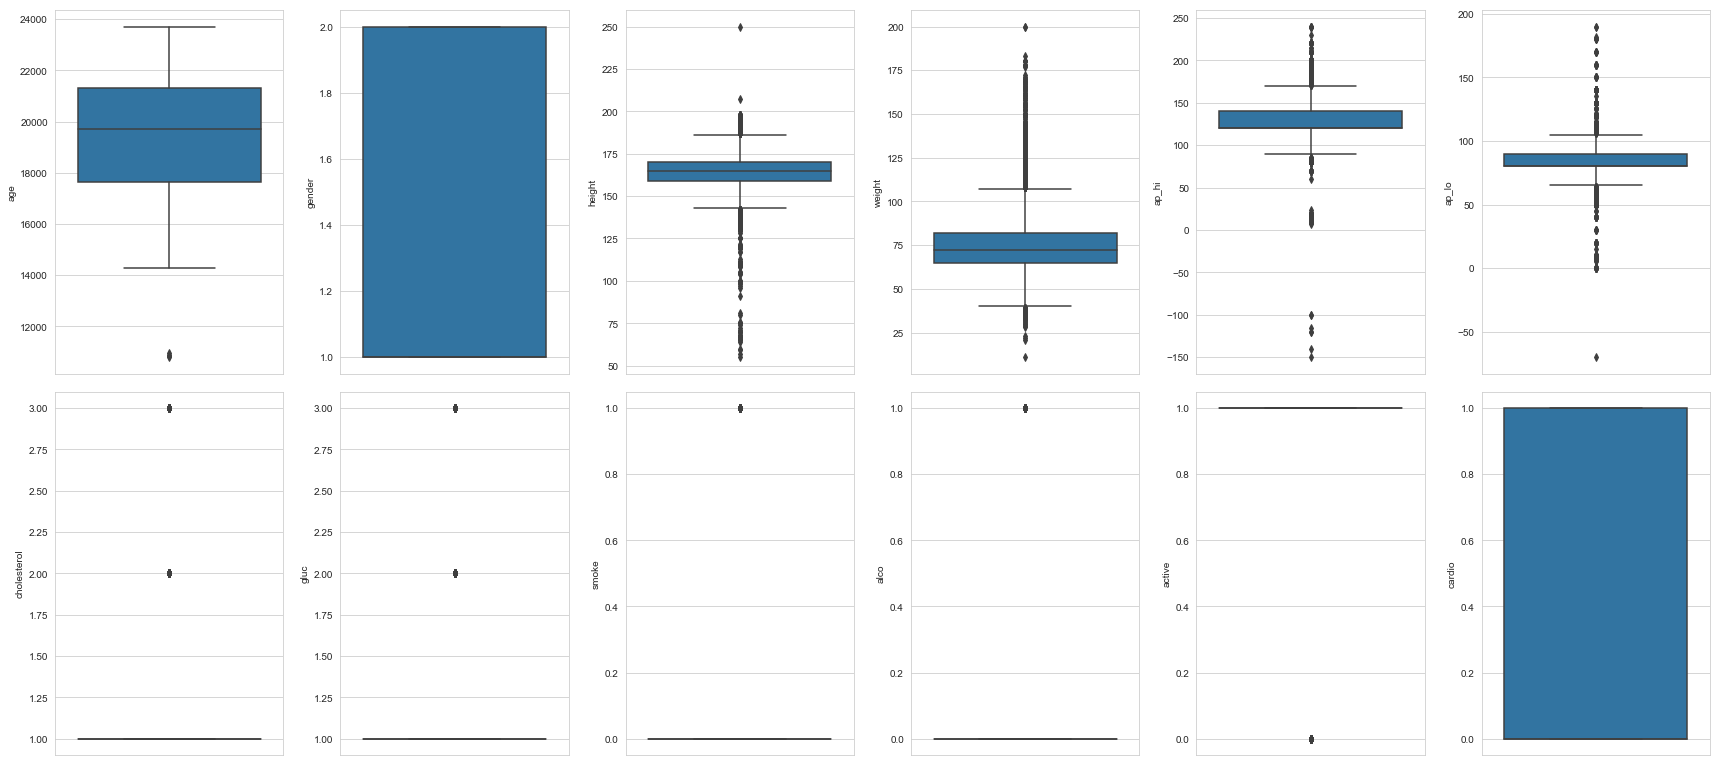

In [10]:
check_outliers(cleaned_df)

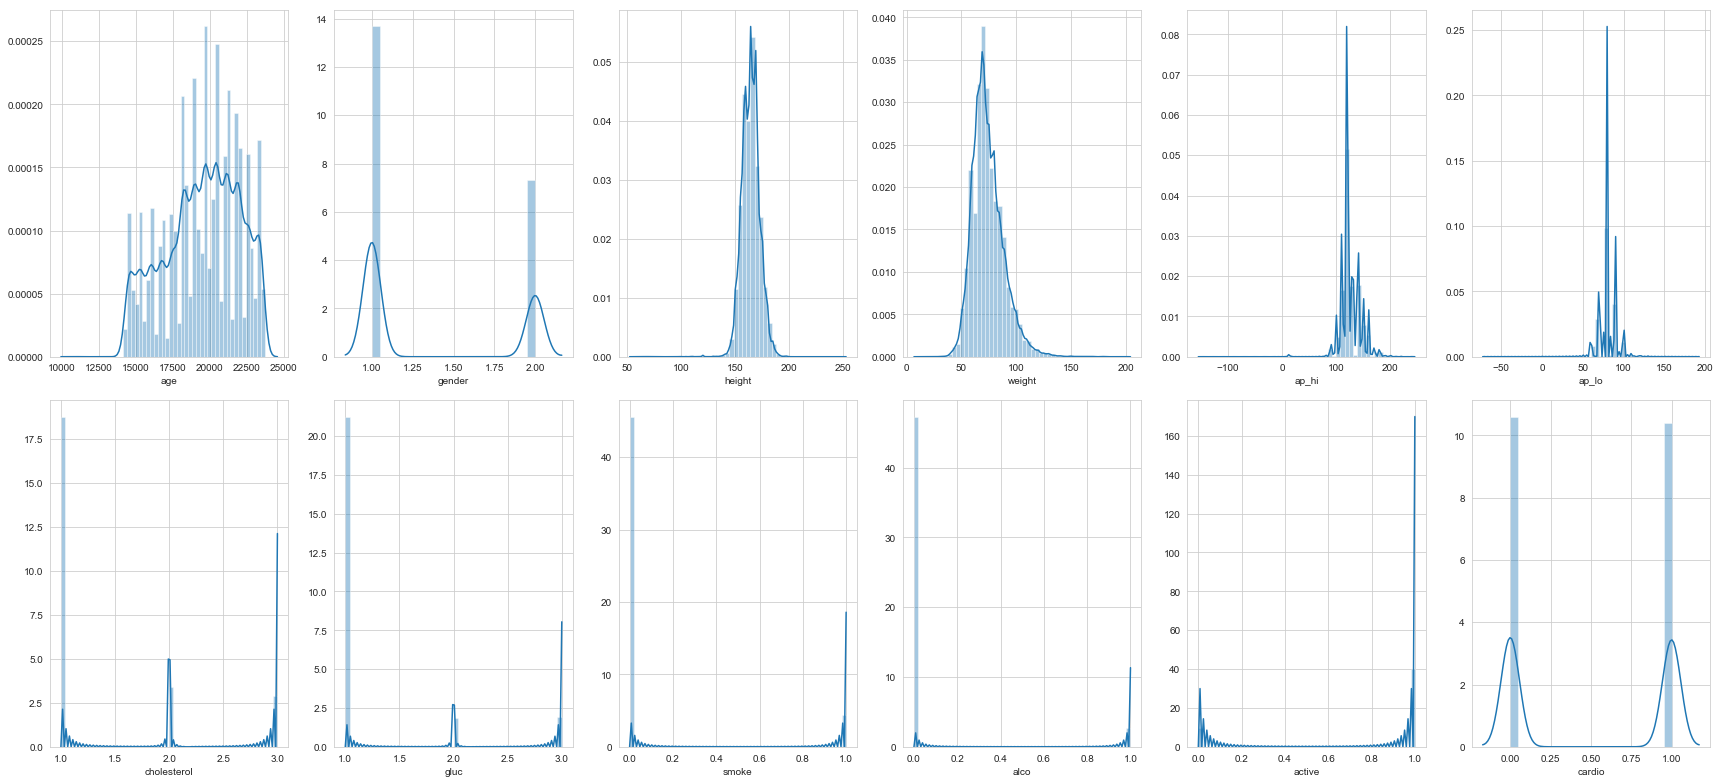

In [11]:
check_dist(cleaned_df)

The dataset was preprocessed to remove outliers in the ap_hi and ap_lo blood pressure features. Only values less than 250 were kept in the data. Through this process, almost 1000 datapoints were discarded, but the resultant distributions depicted in the above bar plots and histograms for ap_hi and ap_lo are roughly normal.

Note that we are dealing with a mix of continuous, ordinal, and binary data, as confirmed from the above data analysis. We can combine all of these data types in one model. Here are a few typical steps we took to preprocess this data before modeling.

- Standardize all continuous features: All continuous input should be standardized. For every continuous feature, compute its mean (𝜇) and standard deviation (𝜎) and calculate 𝑥 = (𝑥−𝜇) / 𝜎.
- Binarize categorical/discrete features (create dummy variables): For all categorical features, represent them as multiple boolean features. For example, instead of having one feature called cholesterol, have 3 boolean features - chol_normal, chol_above_normal, chol_well_above_normal and appropriately set these features to 0 or 1. As can be seen, for every categorical feature, k binary features are added, where k is the number of values that the categorical feature takes.

In [12]:
cont_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
ord_cols = ['cholesterol', 'gluc']
bin_cols = ['gender', 'smoke', 'alco', 'active', 'cardio']

# create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# create an object to transform the data to fit minmax processor
df_scaled = min_max_scaler.fit_transform(cleaned_df[cont_cols])

# run the normalizer on the dataframe
df_normalized = pd.DataFrame(df_scaled)
df_normalized.columns = cont_cols
df_normalized.head()

/Users/caravanuden/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,age,height,weight,ap_hi,ap_lo
0,0.588076,0.579487,0.269841,0.666667,0.576923
1,0.730159,0.517949,0.391534,0.743590,0.615385
2,0.624003,0.564103,0.280423,0.717949,0.538462
3,0.528455,0.584615,0.375661,0.769231,0.653846
4,0.516918,0.517949,0.238095,0.641026,0.500000


In [13]:
for col in ord_cols:
    dummies = pd.get_dummies(cleaned_df[col])
    min_ind = min([ind for ind in dummies.columns])
    dummies.columns = ['{0}_{1}'.format(col, ind) for ind in dummies.columns]
    df_normalized = pd.concat([df_normalized, dummies.drop(['{0}_{1}'.format(col, min_ind)], axis=1)], axis=1)

    
df_normalized.head()

,age,height,weight,ap_hi,ap_lo,cholesterol_2,cholesterol_3,gluc_2,gluc_3
0,0.588076,0.579487,0.269841,0.666667,0.576923,0.0,0.0,0.0,0.0
1,0.730159,0.517949,0.391534,0.743590,0.615385,0.0,1.0,0.0,0.0
2,0.624003,0.564103,0.280423,0.717949,0.538462,0.0,1.0,0.0,0.0
3,0.528455,0.584615,0.375661,0.769231,0.653846,0.0,0.0,0.0,0.0
4,0.516918,0.517949,0.238095,0.641026,0.500000,0.0,0.0,0.0,0.0


In [14]:
df_normalized = pd.concat([df_normalized, cleaned_df[bin_cols]], axis=1)
df_normalized['gender'] -= 1  # shift the categorical labels for gender to be either 0 or 1

df_normalized.head()

,age,height,weight,ap_hi,ap_lo,cholesterol_2,cholesterol_3,gluc_2,gluc_3,gender,smoke,alco,active,cardio
0,0.588076,0.579487,0.269841,0.666667,0.576923,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.730159,0.517949,0.391534,0.743590,0.615385,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.624003,0.564103,0.280423,0.717949,0.538462,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.528455,0.584615,0.375661,0.769231,0.653846,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
4,0.516918,0.517949,0.238095,0.641026,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# save this cleaned data
df_normalized.to_csv('cardio_cleaned.csv', index=False)

We now try to fit Support Vector Machine (SVM) and Random Forest (RF) classifiers on the cleaned dataset.

In [16]:
# try an SVM Classifier
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split

df_normalized= df_normalized.dropna()
print(df_normalized.shape)
X = df_normalized.drop('cardio', axis=1)
y = df_normalized['cardio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42) # 80% training and 20% test

(68030, 14)


In [17]:
# create a svm classifier
clf = svm.SVC() # rbf kernel
# train the model using the training sets
clf.fit(X_train, y_train)

/Users/caravanuden/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [18]:
# evaluate the model
def evaluate_model(clf, X_test, y_test):

    # predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

    # precision: what percentage of positive tuples are labeled as such?
    print("Precision:",metrics.precision_score(y_test, y_pred))

    # recall: what percentage of positive tuples are labelled as such?
    print("Recall:",metrics.recall_score(y_test, y_pred))
    
    # calc auc
#     probas = clf.predict_proba(X_test)
#     auc = roc_auc_score(testy, probs)
#     print('AUC: %.3f' % auc)

In [19]:
evaluate_model(clf, X_test, y_test)

Accuracy: 0.6014258415404968
Precision: 0.67105609691862
Recall: 0.37905385301993455


In [20]:
# try Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# create a Gaussian Classifier
rf_clf = RandomForestClassifier(n_estimators=100)

# train the model using the training sets y_pred=clf.predict(X_test)
rf_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [21]:
evaluate_model(rf_clf, X_test, y_test)

# get feature importances
feature_imp = pd.Series(rf_clf.feature_importances_,index=X_test.columns).sort_values(ascending=False)
feature_imp

Accuracy: 0.5568131706600029
Precision: 0.5552362707535121
Recall: 0.5174055340672419


age              0.362807
weight           0.221246
height           0.191905
ap_hi            0.087422
ap_lo            0.057393
cholesterol_3    0.037828
cholesterol_2    0.009685
gender           0.007249
gluc_3           0.005881
alco             0.005200
gluc_2           0.004789
active           0.004682
smoke            0.003911
dtype: float64

The SVM classifier achieved an accuracy of 0.60 yet had a low recall rate of 0.38. The RF classifier yielded an accuracy of 0.56 and a recall rate of 0.52. There is room for improvement over these baseline predictive models. Future direction may include tuning hyperparameters for the SVM and RF classifiers, or using other types of models, such as linear and logistic regression, Bayesian classifiers, and feed-forward neural networks.